In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel, tims_mse_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')

def load_data(raw, dataset='', validation=False):
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

In [4]:
# # incase i need to save the current model in memory
# def save_model_with_config(train_config, sub_model_key, **kwargs):
#     path = train_config['model_path']
#     prefix = train_config['model_prefix']
#     f = f"{path}/{prefix}{sub_model_key}.pth"
#     torch.save(kwargs, f)

In [5]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [6]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [7]:
train_config = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [8]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG', 'y_BSTAR']
y_test = y_test[y_cols]

Loading data to cache for: sample_test
CPU times: user 388 ms, sys: 564 ms, total: 952 ms
Wall time: 3.45 s


In [9]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
    'y_BSTAR': { 'feature_index': X_test.columns.get_loc('X_BSTAR_1') },
}

Loading existing model
y_ARG_OF_PERICENTER_REG
<function tims_mse_loss at 0x7f00b1a13ee0>


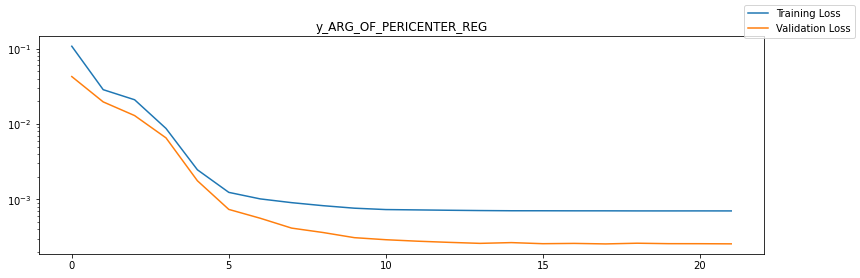

Epoch 22
    Test set MAE (L1) loss: 0.020421649185374764
    Test set MSE (L2) loss: 0.0007273487207703189


,train loss,validation loss
17,0.000703430866,0.000255725126
18,0.000701922464,0.000261263864
19,0.000701696503,0.000257668092
20,0.000702093262,0.000257395915
21,0.000701502103,0.000256264894


,y_ARG_OF_PERICENTER_REG,y_ARG_OF_PERICENTER_REG_pred,X_ARG_OF_PERICENTER_1
0,-0.000193333333,-0.023431384936,0.003265833333
1,0.987631111111,0.970190942287,0.999806666667
2,0.980530833333,0.959637999535,0.987631111111
3,0.976759166667,0.953777909279,0.980530833333
4,0.972732777778,0.949655652046,0.976759166667
...,...,...,...
335637,0.292393888889,0.296915888786,0.350423333333
335638,0.282199444444,0.286678254604,0.340186666667
335639,0.282199444444,0.292025864124,0.350423333333
335640,0.037817777778,0.034097149968,0.079460277778


In [28]:
# Create or load all new sub models here if needed.
# sample_idx = random.sample(list(X_test.index), 10000)
sample_idx = X_test.index
all_models = {}
display_data = []
# for sub_key in y_cols:
for sub_key in ['y_ARG_OF_PERICENTER_REG']:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
        print(f'{sub_key}')
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    print(loss_func)
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    
    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df.add_suffix('_pred'))
    display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
    display(pd.DataFrame(mean_losses, columns=['train loss','validation loss']).tail())
    print('==============================')
    
df = pd.concat(display_data, axis=1)
display(df)

In [11]:
np.abs((df.y_RA_OF_ASC_NODE_REG - df.y_RA_OF_ASC_NODE_REG_pred)).describe()

AttributeError: 'DataFrame' object has no attribute 'y_RA_OF_ASC_NODE_REG'

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly

In [ ]:
nums = ((90 * 360 * np.abs((df.y_REV_MA_REG - df.y_REV_MA_REG_pred)))%360)
nums = np.minimum(nums, np.abs(360-nums))
nums.name = "MEAN_ANOMALY_ERROR"
nums.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999])

In [ ]:
# another model overview
# Load all new sub models here if needed.
all_models = {}
for sub_key in model_configs.keys():
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key, len(X_test.columns), force_recreate=False)
    try:
        tl, vl = zip(*mean_losses)
    except:
        print(f"No data for {sub_key}")
        continue
    print(f'{sub_key}\nEpoch:      {next_epoch}\nLast TLoss: {tl[-1]}\nLast VLoss: {vl[-1]}')
    print(f'Loss func:  {loss_func}\nOptimizer:  {optimizer}')
    print('---------')
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)